### Final Propensity matching results

In [4]:
%reset -f

In [5]:
%load_ext autoreload
%autoreload 2
%load_ext Cython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [6]:
%reload_ext Cython

In [7]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [8]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR, make_MYR_to_date
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )
import data_process
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')
from utils import statistics_first_month, p_val, stat_matrices 
from path import col_seq_can_all, col_seq_can 
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type

In [6]:
# #setup cython
# #for cython build if needed -> cd to /modules folder and then run
# %cd ..
# !python3 setup.py build_ext --inplace
# %cd ./causal_data_creation/canary_application/

In [9]:
%config Completer.use_jedi = False

### Load pre matching data

In [10]:
pp_str = 'Pre_Matching_DATA/'
Path("./"+pp_str).mkdir(exist_ok=True)

In [9]:
# %%time
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/treated2.p ./Pre_Matching_DATA/treated2.p; 
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/controls.p ./Pre_Matching_DATA/controls.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA/pmpm.p ./Pre_Matching_DATA/pmpm.p;
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/tempHybridSelectionMoreData/random.p ./Pre_Matching_DATA/random.p;

In [11]:
treated = pd.read_pickle(pp_str+'treated2.p')
controls = pd.read_pickle(pp_str+'controls.p')
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle(pp_str+'random.p')

In [12]:
pmpm.MBR_GNDR.replace({"F":0,"M":1}, inplace=True)

In [13]:
treated.shape, treated.MYR.min(), treated.MYR.max()

((26040, 91), 201710, 202107)

In [14]:
controls.shape, controls.MYR.min(), controls.MYR.max()

((9582196, 91), 201701, 202107)

In [15]:
pmpm.shape, pmpm.MYR.min(), pmpm.MYR.max()

((9650961, 91), 201701, 202107)

# Check continuity and take average of 1 year history

### Treated

In [15]:
# def get_treated_agg(treated, pmpm):
    
#     #get one year before dates
#     treated_history = pmpm[pmpm.PERS_ID.isin(treated.PERS_ID)]
#     treated.drop(['MEDICAID_LOB'], axis=1, inplace=True)
#     treated['MYR_12'] = treated.MYR.apply(data_process.get_one_year_before, month_offset=12)
    
#     treated_aggregate = pd.DataFrame(columns=col_seq_can_all)
#     for i, (index, row) in tqdm(enumerate(treated.iterrows())):
#         pid = row.PERS_ID
#         myr = row.MYR
#         old_myr = row.MYR_12
#         history = treated_history.query("PERS_ID==@pid & MYR>=@old_myr & MYR<=@myr")
#         agg_data = history[col_seq_can_all].mean()
#         agg_data.PERS_ID = str(int(row.PERS_ID))
#         agg_data.MYR     = int(row.MYR)
#         treated_aggregate = pd.concat([treated_aggregate, pd.DataFrame(agg_data).T], axis=0)
            
#     treated_aggregate.PERS_ID = treated_aggregate.astype(int).astype(str)
#     treated_aggregate.MYR = treated_aggregate.MYR.astype(int)
    
#     treated_aggregate = treated_aggregate.reset_index(drop=True)
    
#     return treated_aggregate
    

In [16]:
# %%time
# treated_aggregate = get_treated_agg(treated.copy(), pmpm.copy())
# treated_aggregate.to_pickle("./FinalData/treated_aggregated_filtered_final_g.p")

In [16]:
sorted_months = treated.MYR.sort_values().unique()

In [17]:
sorted_months

array([201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805,
       201806, 201807, 201808, 201809, 201810, 201811, 201812, 201901,
       201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909,
       201910, 201911, 201912, 202001, 202002, 202003, 202004, 202005,
       202006, 202007, 202008, 202009, 202010, 202011, 202012, 202101,
       202102, 202103, 202104, 202105, 202106, 202107])

In [18]:
treated_aggregate = pd.read_pickle("./Final/Data/PCA/treated_aggregated_filtered_final.p") #goes into matching as tr_agg

In [20]:
# controls_aggregate = data_process.get_average_final_record(controls.copy(), sorted_months, pmpm[col_seq_can_all].copy())
# controls_aggregate.to_pickle("./Final/Data/PCA/controls_aggregated_filtered_final.p")

In [19]:
controls_aggregate = pd.read_pickle("./Final/Data/PCA/controls_aggregated_filtered_final.p")

In [20]:
treated_original = treated[treated.set_index(['PERS_ID','MYR']).index.isin(treated_aggregate.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)
controls_original = controls[controls.set_index(['PERS_ID','MYR']).index.isin(controls_aggregate.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [21]:
del treated, controls

In [24]:
# !aws s3 cp ./Final/Data/PCA/treated_aggregated_filtered_final.p s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/Agg_Data_Common/treated_agg.p --acl bucket-owner-full-control
# !aws s3 cp ./Final/Data/PCA/controls_aggregated_filtered_final.p s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/Agg_Data_Common/controls_agg.p --acl bucket-owner-full-control

# Load Model and Pick Columns for Matching

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [23]:
model = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=16))])

In [24]:
latent_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

In [25]:
onset = "CC_DIABETES"
cols_to_keep = ["PERS_ID", "MYR", 'AGE_AT_MIDMONTH', 'MBR_GNDR',  onset]
extra_cols = ['IP_BIN6', 'ER_BIN6','LOB']

In [26]:
pd.concat([treated_aggregate[col_seq_can_all].loc[:,'AGE_AT_MIDMONTH':], controls_aggregate[col_seq_can_all].loc[:,'AGE_AT_MIDMONTH':]], axis=0)

AGE_AT_MIDMONTH  LOB  MBR_GNDR   ALLOW_AMT  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0              80.769231  1.0       0.0  278.769231       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0       0.000000        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0              1.0   3.307692                    0.0          0.0              0.0     0.846154                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0           0.538462         0.923077             0.0           0.0     0.000000             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0              0.0   
1              80.846154  1.0       0.0  366.076923       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0       0.000000        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0              1.0   3.153846                    0.0          0.0              0.0     0.769231                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0           0.461538         0.923077             0.0           0.0     0.000000             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0              0.0   
2              80.923077  1.0       0.0  376.230769       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0       0.000000        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0              1.0   3.000000                    0.0          0.0              0.0     0.692308                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0           0.384615         0.923077             0.0           0.0     0.000000             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0              0.0   
3              81.076

In [28]:
model.fit(pd.concat([treated_aggregate[col_seq_can_all].loc[:,'AGE_AT_MIDMONTH':], controls_aggregate[col_seq_can_all].loc[:,'AGE_AT_MIDMONTH':]], axis=0))

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=16))])

In [29]:
treated_latent = pd.DataFrame(model.transform(treated_aggregate[col_seq_can_all].loc[:,'AGE_AT_MIDMONTH':]), columns=latent_cols)
treated_latent1 = pd.concat([treated_aggregate[cols_to_keep], treated_original[extra_cols]], axis=1)
treated_latent = pd.concat([treated_latent1, treated_latent], axis=1)

In [30]:
controls_latent = pd.DataFrame(model.transform(controls_aggregate[col_seq_can_all].loc[:,'AGE_AT_MIDMONTH':]), columns=latent_cols)
controls_latent1 = pd.concat([controls_aggregate[cols_to_keep], controls_original[extra_cols]], axis=1)
controls_latent = pd.concat([controls_latent1, controls_latent], axis=1)

In [32]:
del treated_latent1, controls_latent1

In [33]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

all_columns1 = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB',
                                                         'IP_BIN', 'ER_BIN', 'ACUTE', 'IP_C', 'ER_C', 'ACUTE_C','IP_BIN2', 'ER_BIN2']))

all_columns2 = list(set(all_columns1)-set(['IP_BIN6', 'ER_BIN6', 'LOB']))

In [36]:
controls_latent.shape, controls_original.shape

# Matching

In [37]:
%%time
match_on = latent_cols
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict}
matched0, matched_data0 = matched_population(treated_latent.copy(), 
                                           controls_latent.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:271336 before they were:304151


0it [00:00, ?it/s]

IP_BIN6 [0, 1, 2]
ER_BIN6 [0, 1, 2]
LOB None


1568it [1:02:13,  2.38s/it]


There were no matches for 1 out of 1568 patients
CPU times: user 1h 2min 1s, sys: 36min 48s, total: 1h 38min 49s
Wall time: 1h 2min 19s


In [38]:
def get_data(data_struct):
    keys = list(data_struct)
    dat1 = pd.DataFrame()
    for key in keys:
        dat1 = pd.concat([dat1, data_struct[key]], ignore_index=True)
    return dat1

In [39]:
matched_controls_5N = get_data(matched0)

### Result Folder Base

In [40]:
data_base = "./Final/Data/PCA_o/"
result_base = "./Final/results/pca_o/"

In [41]:
matched_controls_5N.to_pickle(data_base+"matched_controls_5N.p")

In [42]:
matched_data0.to_pickle(data_base+"matched_controls_latent.p")

### Calculate matched controls agg and matched controls original 

In [43]:
matched_controls_original = controls_original[controls_original.set_index(['PERS_ID','MYR']).index.isin(matched_data0.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [44]:
matched_controls_original.to_pickle(data_base+"matched_controls_original.p")

In [45]:
matched_controls_aggregate = controls_aggregate[controls_aggregate.set_index(['PERS_ID','MYR']).index.isin(matched_data0.set_index(['PERS_ID','MYR']).index)].reset_index(drop=True)

In [46]:
matched_controls_aggregate.to_pickle(data_base+"matched_controls_aggregate.p")

### List containing all numerical columns

In [47]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

# Statistics First Month Original

In [48]:
# del controls, controls2

In [49]:
treated = pd.read_pickle(pp_str+'treated2.p')

In [50]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_controls_original, all_columns, return_array = True)

pmpm_desc = statistics_first_month(pmpm, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)


CPU times: user 2min 32s, sys: 7.59 s, total: 2min 39s
Wall time: 2min 39s


In [51]:
conds_first

Treated Matched Controls   Test-TC               General Population      Random
                       mean             mean    t-stat          pval               mean        mean
AGE_AT_MIDMONTH   50.205736        50.539097 -0.947121  3.436028e-01          44.310976   47.606399
ALLOW_AMT        693.750000       586.092018  1.450086  1.470695e-01        1065.926022  648.802692
MBR_GNDR           0.205736         0.213308 -0.672492  5.012880e-01           0.442749    0.431056
CC_TOBACCO         0.061097         0.058138  0.457056  6.476420e-01           0.074202    0.098400
CC_PRESSURE        0.001247         0.000678  0.740483  4.590262e-01           0.007390    0.006602
CC_OBESITY         0.456359         0.398835  4.250686  2.152723e-05           0.108841    0.228035
CC_HYPERTENSION    0.324813         0.301802  1.812772  6.990034e-02           0.207717    0.249365
CC_HYPOTHYROID     0.094763         0.087681  0.902968  3.665669e-01           0.047300    0.063484
CC_DX_CNT          2.706359         2.403171  5.514312  3.598556e-08           1.824419    2.343702
ACUTE2             0.038653         0.025884  2.684859  7.269365e-03           0.063258    0.051549
ACUTE6             0.111596         0.083345  2.926512  3.436452e-03           0.063258    0.153377
IP_BIN6            0.028055         0.018295  2.184172  2.897535e-02           0.020587    0.046851
ER_BIN6            0.088529         0.067082  2.537591  1.117859e-02           0.047286    0.116176
LOB                0.951995         0.925193  3.815117  1.370310e-04           0.755775    0.787836

In [53]:
conds_first.to_csv(result_base+"stats_matching/conds_original_first.csv", index=True, header=True)
full_first.to_csv(result_base+"stats_matching/full_original_first.csv", index=True, header=True)
conds_firstAllCols.to_csv(result_base+"stats_matching/conds_original_first_allcols.csv", index=True, header=True)
full_firstAllCols.to_csv(result_base+"stats_matching/full_original_first_allcols.csv", index=True, header=True)

# Latent First Month

In [54]:
%%time
tr_desc0_l, treated_first_month_l = statistics_first_month(treated_latent, latent_cols, return_array = True)
con_desc0_l, controls_first_month_l = statistics_first_month(matched_data0, latent_cols, return_array = True)

conds_lat, full_lat = stat_matrices(tr_desc0_l, con_desc0_l, tr_desc0_l, tr_desc0_l, columns = latent_cols)


CPU times: user 2.73 s, sys: 8.21 ms, total: 2.74 s
Wall time: 2.74 s


In [55]:
conds_lat

Treated Matched Controls   Test-TC               General Population    Random
         mean             mean    t-stat          pval               mean      mean
x1  -0.534534        -0.725751  5.133169  2.908967e-07          -0.534534 -0.534534
x2  -0.071293        -0.161689  2.561453  1.043978e-02          -0.071293 -0.071293
x3  -0.022466        -0.001366 -0.842054  3.997803e-01          -0.022466 -0.022466
x4  -0.155696        -0.126976 -1.033216  3.015309e-01          -0.155696 -0.155696
x5   0.051170        -0.008466  2.706053  6.821722e-03           0.051170  0.051170
x6  -0.420249        -0.395872 -0.977861  3.281694e-01          -0.420249 -0.420249
x7   0.093563         0.023532  3.779189  1.583618e-04           0.093563  0.093563
x8   0.247998         0.194301  2.418588  1.560070e-02           0.247998  0.247998
x9   0.088142         0.092354 -0.196887  8.439201e-01           0.088142  0.088142
x10  0.002999        -0.017988  1.131624  2.578230e-01           0.002999  0.002999
x11 -0.024487        -0.022513 -0.092669  9.261684e-01          -0.024487 -0.024487
x12 -0.016114         0.041983 -3.195344  1.401495e-03          -0.016114 -0.016114
x13  0.095108         0.070919  1.298992  1.939801e-01           0.095108  0.095108
x14 -0.044512        -0.045244  0.033937  9.729280e-01          -0.044512 -0.044512
x15 -0.112690        -0.062622 -2.235164  2.543119e-02          -0.112690 -0.112690
x16  0.102006         0.082489  1.062848  2.878796e-01           0.102006  0.102006

In [56]:
conds_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_lat_first.csv", index=True, header=True)
full_lat[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_lat_first.csv", index=True, header=True)

# Agg First Month

In [57]:
%%time
without_custom_cols = [cols for cols in all_columns if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]
selected_without_custom_cols = [cols for cols in columns_to_match if cols not in ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ER_BIN', 'IP_BIN6', 'ACUTE6', 'ACUTE_C', 'ACUTE', 'IP_BIN', 'PREGNANCY', 'ER_BIN6', 'IP_C', 'ER_C']]

tr_desc0_agg, treated_agg_first_month = statistics_first_month(treated_aggregate, without_custom_cols, return_array = True)
con_desc0_agg, controls_agg_first_month = statistics_first_month(matched_controls_aggregate, without_custom_cols, return_array = True)

conds_agg, full_agg = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllCols, full_aggAllCols = stat_matrices(tr_desc0_agg, con_desc0_agg, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)


CPU times: user 3.4 s, sys: 4.03 ms, total: 3.4 s
Wall time: 3.4 s


In [58]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].round(3)

Treated Matched Controls Test-TC       
                    mean             mean  t-stat   pval
AGE_AT_MIDMONTH   49.948           50.066  -0.333  0.739
ALLOW_AMT        781.696          558.800   6.201  0.000
MBR_GNDR           0.205            0.213  -0.700  0.484
CC_TOBACCO         0.055            0.055   0.015  0.988
CC_PRESSURE        0.001            0.000   1.310  0.190
CC_OBESITY         0.419            0.372   3.755  0.000
CC_HYPERTENSION    0.314            0.293   1.826  0.068
CC_HYPOTHYROID     0.088            0.083   0.656  0.512
CC_DX_CNT          2.537            2.280   4.996  0.000
LOB                0.953            0.925   3.972  0.000

In [59]:
conds_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_first.csv", index=True, header=True)
full_agg[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_first.csv", index=True, header=True)
conds_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_first_allcols.csv", index=True, header=True)
full_aggAllCols[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_first_allcols.csv", index=True, header=True)

# Stat all Original

In [60]:
%%time
tr_desc0A = treated[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_controls_original[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

pmpm_descA = pmpm[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)


CPU times: user 29.2 s, sys: 2.4 s, total: 31.6 s
Wall time: 31.6 s


In [61]:
conds.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   50.837           51.552  -8.332  0.000             50.379   50.236
ALLOW_AMT        782.435          660.547   4.722  0.000            857.856  706.609
MBR_GNDR           0.189            0.200  -3.708  0.000              0.433    0.429
CC_TOBACCO         0.063            0.066  -1.763  0.078              0.102    0.100
CC_PRESSURE        0.002            0.002   0.998  0.318              0.013    0.008
CC_OBESITY         0.505            0.422  24.181  0.000              0.255    0.286
CC_HYPERTENSION    0.325            0.314   3.391  0.001              0.329    0.300
CC_HYPOTHYROID     0.095            0.096  -0.339  0.735              0.078    0.075
CC_DX_CNT          2.918            2.626  20.151  0.000              2.955    2.759
ACUTE2             0.032            0.031   1.101  0.271              0.060    0.050
ACUTE6             0.100            0.092   3.229  0.001              0.168    0.150
IP_BIN6            0.025            0.024   0.669  0.503              0.055    0.049
ER_BIN6            0.079            0.071   3.594  0.000              0.122    0.111
LOB                0.953            0.922  17.398  0.000              0.802    0.803

In [62]:
conds.to_csv(result_base+"stats_matching/conds_original.csv", index=True, header=True)
full.to_csv(result_base+"stats_matching/full_original.csv", index=True, header=True)
conds_AllCols.to_csv(result_base+"stats_matching/conds_original_allcols.csv", index=True, header=True)
full_AllCols.to_csv(result_base+"stats_matching/full_original_allcols.csv", index=True, header=True)

# Latent Alltime

In [63]:
%%time
tr_desc0_latA = treated_latent[latent_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_latA['count'] = tr_desc0_latA['count'].astype(int)

con_desc0_latA = matched_data0[latent_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_latA['count'] = con_desc0_latA['count'].astype(int)

conds_latA, full_latA = stat_matrices(tr_desc0_latA, con_desc0_latA, tr_desc0_latA, tr_desc0_latA, columns = latent_cols)


CPU times: user 159 ms, sys: 0 ns, total: 159 ms
Wall time: 159 ms


In [64]:
treated_latent[latent_cols].mean()*(10**14)

x1    -3.836837e+13
x2     1.884326e+12
x3    -5.354675e+12
x4    -2.706674e+13
x5     5.841051e+11
x6    -5.086429e+13
x7     1.665465e+13
x8     2.711709e+13
x9     6.743449e+12
x10    1.542404e+12
x11   -2.475811e+12
x12   -6.537423e+12
x13    1.070235e+13
x14   -4.514843e+12
x15   -1.277662e+13
x16    9.895782e+12
dtype: float64

In [65]:
full_latA

Treated                  Matched Controls                      Test-TC                General Population                  Test-TG         Random                  Test-TR     
         mean       std  count             mean       std   count     t-stat           pval               mean       std  count  t-stat pval      mean       std  count  t-stat pval
x1  -0.383684  1.559850  24495        -0.561125  1.394609  108905  17.591476   3.429102e-69          -0.383684  1.559850  24495     0.0  1.0 -0.383684  1.559850  24495     0.0  1.0
x2   0.018843  1.453474  24495        -0.103970  1.257824  108905  13.401013   6.339896e-41           0.018843  1.453474  24495     0.0  1.0  0.018843  1.453474  24495     0.0  1.0
x3  -0.053547  0.819782  24495        -0.021811  0.786529  108905  -5.661145   1.506743e-08          -0.053547  0.819782  24495     0.0  1.0 -0.053547  0.819782  24495     0.0  1.0
x4  -0.270667  1.065386  24495        -0.193796  0.953485  108905 -11.149273   7.434793e-29          -0.270667  1.065386  24495     0.0  1.0 -0.270667  1.065386  24495     0.0  1.0
x5   0.005841  1.000677  24495        -0.024994  0.968949  108905   4.472969   7.720456e-06           0.005841  1.000677  24495     0.0  1.0  0.005841  1.000677  24495     0.0  1.0
x6  -0.508643  0.966952  24495        -0.454038  0.938080  108905  -8.184677   2.754097e-16          -0.508643  0.966952  24495     0.0  1.0 -0.508643  0.966952  24495     0.0  1.0
x7   0.166547  0.656615  24495         0.067332  0.660790  108905  21.256884  4.177664e-100           0.166547  0.656615  24495     0.0  1.0  0.166547  0.656615  24495     0.0  1.0
x8   0.271171  0.904013  24495         0.229649  0.846302  108905   6.849919   7.421014e-12           0.271171  0.904013  24495     0.0  1.0  0.271171  0.904013  24495     0.0  1.0
x9   0.067434  0.785125  24495         0.083259  0.753030  108905  -2.948192   3.196940e-03           0.067434  0.785125  24495     0.0  1.0  0.067434  0.785125  24495     0.0  1.0
x10  0.015424  0.666074  24495        -0.015310  0.585159  108905   7.233620   4.727974e-13           0.015424  0.666074  24495     0.0  1.0  0.015424  0.666074  24495     0.0  1.0
x11 -0.024758  0.843777  24495        -0.021325  0.792688  108905  -0.605066   5.451362e-01          -0.024758  0.843777  24495     0.0  1.0 -0.024758  0.843777  24495     0.0  1.0
x12 -0.065374  0.758088  24495         0.020656  0.694089  108905 -17.225100   2.031795e-66          -0.065374  0.758088  24495     0.0  1.0 -0.065374  0.758088  24495     0.0  1.0
x13  0.107024  0.781432  24495         0.076929  0.718475  108905   5.826226   5.682448e-09           0.107024  0.781432  24495     0.0  1.0  0.107024  0.781432  24495     0.0  1.0
x14 -0.045148  0.913675  24495        -0.053929  0.791948  108905   1.522316   1.279323e-01          -0.045148  0.913675  24495     0.0  1.0 -0.045148  0.913675  24495     0.0  1.0
x15 -0.127766  0.924029  24495        -0.072750  0.831497  108905  -9.161072   5.208324e-20          -0.127766  0.924029  24495     0.0  1.0 -0.127766  0.924029  24495     0.0  1.0
x16  0.098958  0.762934  24495         0.090231  0.666141  108905   1.801827   7.157487e-02           0.098958  0.762934  24495     0.0  1.0  0.098958  0.762934  24495     0.0  1.0

In [66]:
conds_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_lat_allcols.csv", index=True, header=True)
full_latA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_lat_allcols.csv", index=True, header=True)

# Agg alltime

In [67]:
%%time
tr_desc0_aggA = treated_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
tr_desc0_aggA['count'] = tr_desc0_aggA['count'].astype(int)

con_desc0_aggA = matched_controls_aggregate[without_custom_cols].describe().loc[['mean', 'std', 'count']].T
con_desc0_aggA['count'] = con_desc0_aggA['count'].astype(int)

conds_aggA, full_aggA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = selected_without_custom_cols)
conds_aggAllColsA, full_aggAllColsA = stat_matrices(tr_desc0_aggA, con_desc0_aggA, tr_desc0_agg, tr_desc0_agg, columns = without_custom_cols)



CPU times: user 660 ms, sys: 0 ns, total: 660 ms
Wall time: 659 ms


In [68]:
conds_aggA

Treated Matched Controls    Test-TC                General Population      Random
                       mean             mean     t-stat           pval               mean        mean
AGE_AT_MIDMONTH   50.580075        51.061801  -5.485001   4.142140e-08          49.947968   49.947968
ALLOW_AMT        808.023126       630.445195  15.505211   3.567294e-54         781.696414  781.696414
MBR_GNDR           0.191590         0.199587  -2.837177   4.552120e-03           0.205357    0.205357
CC_TOBACCO         0.062304         0.062976  -0.411066   6.810249e-01           0.055015    0.055015
CC_PRESSURE        0.001699         0.001457   0.972083   3.310109e-01           0.001226    0.001226
CC_OBESITY         0.496366         0.415699  24.751601  6.021579e-135           0.418996    0.418996
CC_HYPERTENSION    0.326315         0.312567   4.561636   5.080170e-06           0.313737    0.313737
CC_HYPOTHYROID     0.092917         0.092319   0.316574   7.515672e-01           0.087809    0.087809
CC_DX_CNT          2.828596         2.528927  21.989854  5.586178e-107           2.536723    2.536723
LOB                0.955921         0.923093  18.312187   8.175204e-75           0.953023    0.953023

In [69]:
conds_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg.csv", index=True, header=True)
full_aggA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg.csv", index=True, header=True)
conds_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/conds_agg_allcols.csv", index=True, header=True)
full_aggAllColsA[['Treated', 'Matched Controls', 'Test-TC']].to_csv(result_base+"stats_matching/full_agg_allcols.csv", index=True, header=True)

# Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Figures for the paper

In [70]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [71]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [72]:
base_path =  result_base
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [73]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

#### Remove %%capture to see output

In [74]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


In [75]:
%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

In [76]:
%%capture
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

# Standardized Means Graph

In [77]:
tr_desc0, treated_first_month = statistics_first_month(treated, columns_to_match, return_array = True)

In [78]:
con_desc0, controls_first_month = statistics_first_month(matched_controls_original, columns_to_match, return_array = True)

In [79]:
controls_original.shape, matched_controls_original.shape

In [80]:
un_controls_ = controls_original[columns_to_match].describe().loc[['mean', 'std', 'count']].T

In [81]:
un_controls_all = controls_original[all_columns].describe().loc[['mean', 'std', 'count']].T

In [82]:
un_controls_all.to_csv(result_base+"stats_matching/unmatched_all_cols_stats.csv", index=True, header=True)

In [83]:
pooled = (tr_desc0['std']* len(treated) + un_controls_['std']*len(controls_original))/(len(treated)+len(controls_original))

In [84]:
stdMeans = pd.DataFrame()
stdMeans['Treated'] = tr_desc0['mean']/pooled
stdMeans['Controls'] = un_controls_['mean']/pooled
stdMeans['MControls'] = con_desc0['mean']/pooled

In [85]:
stdMeans

Treated  Controls  MControls
AGE_AT_MIDMONTH  2.608468  2.686381   2.625788
ALLOW_AMT        0.148225  0.187066   0.125223
MBR_GNDR         0.415457  0.875053   0.430748
CC_TOBACCO       0.197653  0.346797   0.188080
CC_PRESSURE      0.010585  0.120098   0.005752
CC_OBESITY       1.006217  0.637581   0.879382
CC_HYPERTENSION  0.679138  0.740844   0.631026
CC_HYPOTHYROID   0.339865  0.304591   0.314466
CC_DX_CNT        0.909817  1.077759   0.807892
ACUTE2           0.152936  0.227996   0.102414
ACUTE6           0.213735  0.335652   0.159626
IP_BIN6          0.095697  0.199877   0.062406
ER_BIN6          0.204459  0.292982   0.154928
LOB              2.433451  2.071915   2.364941

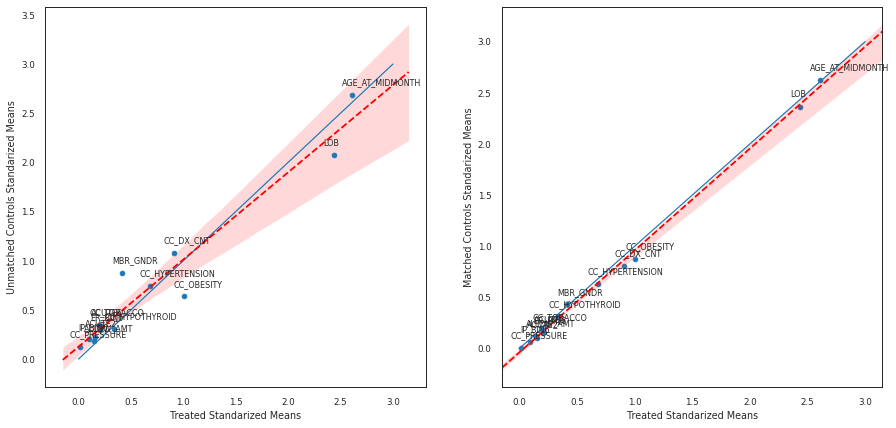

In [86]:
fig, ax = plt.subplots(1,2, figsize = (15,7))
ax[0].plot([0,3], [0, 3])
ax[1].plot([0,3], [0, 3])
ax[0].set_xlabel('Treated Standarized Means')
ax[0].set_ylabel('Unmatched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['Controls'].values,scatter = False, ax = ax[0],line_kws={"color": "red","linestyle" : '--'
})

ax[0].scatter(stdMeans['Treated'], stdMeans['Controls'])
ax[1].scatter(stdMeans['Treated'], stdMeans['MControls'])
ax[1].set_xlabel('Treated Standarized Means')
ax[1].set_ylabel('Matched Controls Standarized Means')
sns.regplot(stdMeans['Treated'].values, stdMeans['MControls'].values, scatter = False,ax = ax[1], line_kws={"color": "red","linestyle" : '--'
})
for i, name in enumerate(list(stdMeans.index)):
    ax[0].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['Controls'].iloc[i]), fontsize = 'small',
                   textcoords = 'offset points',xytext = (-10,10))
    ax[1].annotate(name, (stdMeans['Treated'].iloc[i],stdMeans['MControls'].iloc[i]),fontsize = 'small',
                   textcoords = 'offset points', xytext = (-10,10))

fig.savefig(result_base+"figures/std_means_graph.png")
fig.show()

# Ratio Stats

In [87]:
disease_cols = [cols for cols in treated.columns if "CC" in cols and cols!='CC_DX_CNT']
other_binary_cols = ['MBR_GNDR', 'LOB', 'PREGNANCY', 'IP_BIN', 'ER_BIN', 'ACUTE']
binary_cols = other_binary_cols + disease_cols 
restricted_cols = ['PERS_ID', 'MYR', 'MEDICAID_LOB']
continuous_cols = [cols for cols in treated.columns if cols not in binary_cols + restricted_cols]

In [88]:
def calculate_continuous_d(t, c):
    Xt = np.mean(t)
    Xc = np.mean(c)
    St = np.std(t)
    Sc = np.std(c)
    d = np.abs((Xt-Xc)/(np.sqrt((St**2 + Sc**2)/2)))
    return d

In [89]:
def calculate_binary_d(t, c):
    Pt = np.mean(t)
    Pc = np.mean(c)
    d = np.abs((Pt-Pc)/(np.sqrt((Pt*(1-Pt)+Pc*(1-Pc))/2)))
    return d

In [90]:
d_metric_before = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated_original[[col]].values, controls_original[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated_original[[col]].values, controls_original[[col]].values)
        d_metric_before.loc[0,col] = d

In [91]:
d_metric_before

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0   0.54025         0.038863   0.017102  0.007147  0.021577  0.018774      0.121471           0.202374  0.053294   0.046514             0.105468      0.025743   0.084555       0.145405   0.096304    0.034489  0.145498          0.076516     0.043088            0.01594           0.272186              0.049306  0.13852             0.02959       0.061509                 0.062788            0.05059     0.397714         0.121306   0.080205               0.011875     0.058982         0.005191     0.065073           0.051957          0.133201        0.013848              0.002869                0.019984               0.02383                0.065898                    0.046573        0.005502        0.004032          0.071051         0.059537           0.097063         0.050973        0.043779      0.068314     0.172573        0.053973      0.004021  0.031985        0.048055     0.180443            0.061977               0.061581               0.029496    0.486435         0.084021   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN    ER_BIN     ACUTE      IP_C      ER_C   ACUTE_C   IP_BIN6   ER_BIN6  ACUTE6   IP_BIN2   ER_BIN2    ACUTE2  
0       0.192597        0.005469     0.129215            0.099813  0.026201          0.080329                0.115778        0.049092         0.007018   0.066658    0.154327            0.010869          0.046064  0.460482   0.034817  0.068095  0.066718  0.088808  0.075701  0.006985  0.017054  0.137033  0.117808  0.1595  0.090354  0.084982  0.113792

In [92]:
d_metric_before.T.to_csv(result_base+"stats_matching/d_metric_before.csv", header=True, index=True)

In [93]:
d_metric_before.T[d_metric_before.T[0]<0.1].size

65

In [94]:
d1 = d_metric_before.loc[:,:'LOB']

In [95]:
d1

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0   0.54025         0.038863   0.017102  0.007147  0.021577  0.018774      0.121471           0.202374  0.053294   0.046514             0.105468      0.025743   0.084555       0.145405   0.096304    0.034489  0.145498          0.076516     0.043088            0.01594           0.272186              0.049306  0.13852             0.02959       0.061509                 0.062788            0.05059     0.397714         0.121306   0.080205               0.011875     0.058982         0.005191     0.065073           0.051957          0.133201        0.013848              0.002869                0.019984               0.02383                0.065898                    0.046573        0.005502        0.004032          0.071051         0.059537           0.097063         0.050973        0.043779      0.068314     0.172573        0.053973      0.004021  0.031985        0.048055     0.180443            0.061977               0.061581               0.029496    0.486435         0.084021   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  
0       0.192597        0.005469     0.129215            0.099813  0.026201          0.080329                0.115778        0.049092         0.007018   0.066658    0.154327            0.010869          0.046064  0.460482

In [96]:
d1.T[d1.T[0]<0.1].size

56

In [97]:
d_metric_after = pd.DataFrame()
for col in treated.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated_original[[col]].values, matched_controls_original[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated_original[[col]].values, matched_controls_original[[col]].values)
        d_metric_after.loc[0,col] = d

In [98]:
d_metric_after.T.to_csv(result_base+"stats_matching/d_metric_after.csv", header=True, index=True)

In [99]:
d_metric_after.T[d_metric_after.T[0]<0.1].size

78

In [100]:
d2 = d_metric_after.loc[:,:'LOB']

In [101]:
d2.T[d2.T[0]<0.1].size

65

In [102]:
ratio = d_metric_after/d_metric_before
ratio

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.037319         0.988236   2.130207  2.900749  0.113478  4.214511      0.153792           0.218069  0.114603   0.598542             0.262319      1.027098   1.018355       0.214048    0.19639    2.078036  0.079508          0.582851     0.841897           0.077215           0.157638              0.271877  0.28943            0.327156        1.12923                 0.061812           0.010725     0.436526         0.265787   2.101182               0.970943     0.526467         2.292892     0.456519           0.321504          0.309577             NaN              8.087515                0.252591                   NaN                0.027853                    0.009237             NaN             NaN          0.015268         0.449585           0.147046         0.658385        0.135945      0.112712     0.117725        0.164436      2.005683  1.810016        0.424932     0.639768            0.215143               0.077438                    NaN    0.410627         0.114929   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY   IP_BIN    ER_BIN     ACUTE      IP_C      ER_C   ACUTE_C  IP_BIN6  ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2    ACUTE2  
0       0.197645        9.766212     0.075116            0.017179  2.722377          0.032333                0.081075        0.161585          4.19724   0.207446    0.058859            2.224747          0.339785  0.297871   0.431808  0.01367  0.069497  0.042873  0.905568  8.667712  4.248341  0.06258  0.21238  0.149951  0.004898  0.115263  0.076003

In [103]:
ratio.T[ratio.T[0]>=1.0].size

18

In [104]:
ratio.T.to_csv(result_base+"stats_matching/ratio.csv", header=True, index=True)

In [ ]:
!aws s3 cp ../Final/Data/PCA s3://cdphp-s3-us-e-p-pond/rpi/nneehal/DATA/CanaryPaper/PCAFixedFinal --recursive --acl bucket-owner-full-control